In [ ]:
from glob import glob
from explicit_memory.utils import read_yaml
import pandas as pd

table = {"l": {8: [], 16: []}, "l2": {8: [], 16: []}}
for results_path in sorted(glob("./training_results/explore/LSTM/*/results.yaml")):
    train_path = results_path.replace("results.yaml", "train.yaml")

    results = read_yaml(results_path)
    train = read_yaml(train_path)

    test_score = results["test_score"]
    sorted_val = sorted(results["validation_score"], key=lambda x: x["mean"])
    val_score = sorted_val[-1]

    try:
        table[train["env_config"]["room_size"]][train["capacity"]["episodic"]].append(
            {
                "test_mean": test_score["mean"],
                "test_std": test_score["std"],
                "val_mean": val_score["mean"],
                "val_std": val_score["std"],
                "gamma": train["gamma"],
                # "pretrain_semantic": train["pretrain_semantic"],
                "batch_size": train["batch_size"],
                "dir": results_path.split("/")[-2],
                "test_seed": train["test_seed"],
                # "target_update_interval": train["target_update_interval"],
                "mm_agent_path": train["mm_agent_path"].split("/")[-2],
            }
        )
    except KeyError:
        pass

for room_size in ["l", "l2"]:
    for capacity in [8, 16]:
        table[room_size][capacity] = sorted(
            table[room_size][capacity], key=lambda x: x["test_mean"], reverse=True
        )
table = pd.DataFrame([foo for foo in table["l"][16]])
table

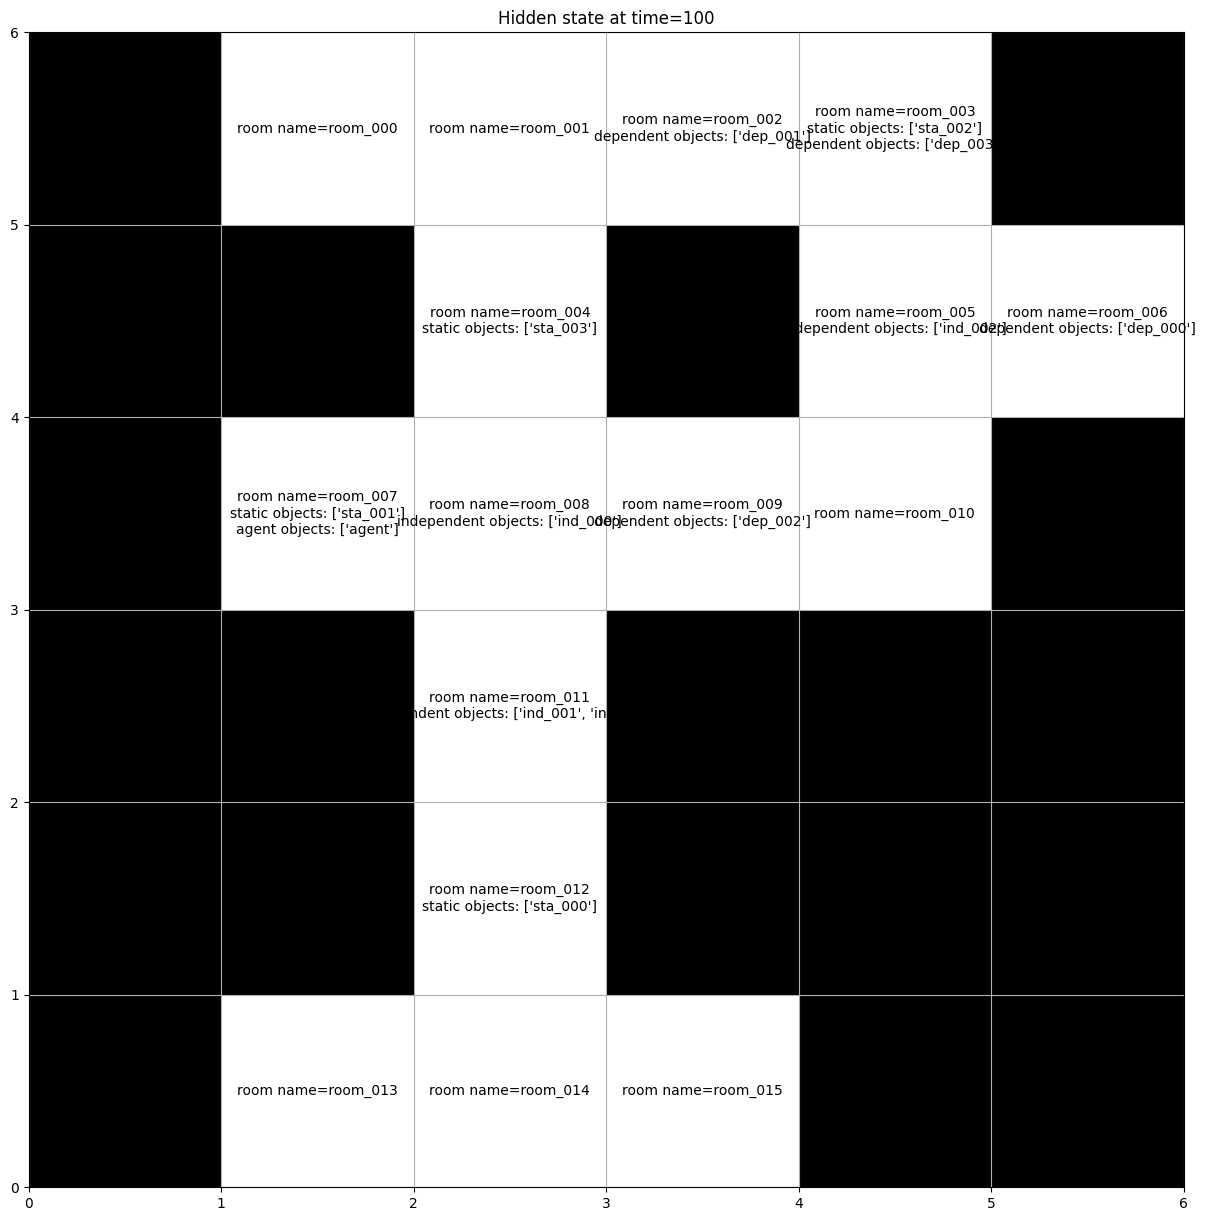

504


In [1]:
from explicit_memory.visualize_results import save_figs_and_memories

save_figs_and_memories(
    agent_dir="./trained-agents/lstm-explore/2024-01-06 20:04:03.511403/",
    mm_policy="neural",
    qa_policy="episodic_semantic",
    explore_policy="neural",
    test_seed=1
)

In [ ]:
from glob import glob
from explicit_memory.utils import read_yaml
import pandas as pd

table = {"l": {8: [], 16: []}, "l2": {8: [], 16: []}}
for results_path in sorted(glob("./training_results/mm/LSTM/*/results.yaml")):
    train_path = results_path.replace("results.yaml", "train.yaml")

    results = read_yaml(results_path)
    train = read_yaml(train_path)

    test_score = results["test_score"]
    sorted_val = sorted(results["validation_score"], key=lambda x: x["mean"])
    val_score = sorted_val[-1]

    try:
        table[train["env_config"]["room_size"]][train["capacity"]["episodic"]].append(
            {
                "test_mean": test_score["mean"],
                "test_std": test_score["std"],
                "val_mean": val_score["mean"],
                "val_std": val_score["std"],
                "gamma": train["gamma"],
                # "pretrain_semantic": train["pretrain_semantic"],
                "batch_size": train["batch_size"],
                "dir": results_path.split("/")[-2],
                "test_seed": train["test_seed"],
            }
        )
    except KeyError:
        pass

for room_size in ["l", "l2"]:
    for capacity in [8, 16]:
        table[room_size][capacity] = sorted(
            table[room_size][capacity], key=lambda x: x["test_mean"], reverse=True
        )

In [ ]:
pd.DataFrame([foo for foo in table["l"][16]])

In [ ]:
pd.DataFrame([foo for foo in table["l"][16]]).test_mean.mean(), pd.DataFrame([foo for foo in table["l"][16]]).test_mean.std()

In [ ]:
pd.DataFrame([foo for foo in table["l"][16]]).val_mean.mean(), pd.DataFrame([foo for foo in table["l"][16]]).val_mean.std()